# Notebook to obtain wind effect for CMIP6 models using regression

In [159]:
import xarray as xr
import numpy as np
import pandas as pd
import pickle
import copy



from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Obtain wind effect over historical period

### Import sea level and windstress data

In [160]:
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/cmip6'

In [161]:
sealevel_data = xr.open_dataset(f'{path}/regression input/sealevel_his.nc')

In [162]:
windstress_data = xr.open_dataset(f'{path}/regression input/windstress_his.nc')

In [163]:
stations = sealevel_data.station.data

In [164]:
sealevel_data

<xarray.Dataset>
Dimensions:  (station: 7, model: 43, time: 165)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) float64 1.85e+03 1.852e+03 1.852e+03 ... 2.014e+03 2.014e+03
  * station  (station) object 'Vlissingen' 'Hoek v. Holland' ... 'Average'
Data variables:
    zos      (station, model, time) float64 ...
Attributes:
    emission_scenario:  historical
    source_file:        This NetCDF file was built from PreparePlaneVariables.py
    creation_date:      2021-09-23 10:13

### Perform regression

In [165]:
def regression(sea_data, wind_data):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.time.data
    trend = [j - trend[0] for j in trend]
    
    
    # Create lists containing names of regression terms
    regg_names = ['u$^2$', 'v$^2$', 'trend']
    wind_names = ['u$^2$', 'v$^2$']
    
    
    # Create lists to save datasets
    timeseries_lst2 = []
    reg_results_lst = []
    
    
    
    
    
    
    # Perform regression for each model
    for model in wind_data.model.data:

        # Create lists to save variables
        timeseries_lst = []
        coef_lst = []
        intercept_lst = []
        rmse_lst = []
        R2_total_lst = []
        R2_wind_lst = []
        R2_u2_lst = []
        R2_v2_lst = []
    
        # Create dictionary for scales of standardization
        scalers = {}
        
        # Perform regression for each station
        for station in stations:
            y = pd.DataFrame(data={'time': sea_data.time.values,
                                   'sealevel': sea_data.zos.sel(model=model, station=station).values})
            
            y = y.set_index('time')
            
            
            # Create x dataframe with timeseries used in the regression
            x = pd.DataFrame(data={'time': wind_data.time.values, 
                                       'u$^2$' : wind_data.u2.sel(model=model, station=station).values, 
                                       'v$^2$' : wind_data.v2.sel(model=model, station=station).values, 
                                       'trend': trend})
            x = x.set_index('time')
                
                
            # Define regression
            regression_ = linr()
            
            
            # Interpolate to remove nan values
            x = x.interpolate(axis=0)
            y = y.interpolate(axis=0)

            
            # Standardize x and save scaler for projections
            scaler = StandardScaler()
            scalers[station] = scaler.fit(x)
            
            
            
            x = copy.deepcopy(x)
            x.iloc[:,:] = scaler.fit_transform(x)


            # Create copy such that regression result can be obtained for full time series
            x_timeseries = copy.deepcopy(x)
            
            
            # Perform regression with sea-level data untill 1980, thereafter the sea level accelerates
            y = y[y.index <= 1980]
        
            
            # Create dataframes of equal time span
            y = y[y.index.isin(x.index)]
            x = x[x.index.isin(y.index)]
            
            
            fit = regression_.fit(x, y.values.ravel())
            intercept_lst.append(regression_.intercept_)
            coef_lst.append(regression_.coef_.tolist())
            
            
            
            # Calculate rmse
            yhat = regression_.predict(x)
            mse = mean_squared_error(y, yhat) # Calculate insample mse
            rmse_lst.append(np.sqrt(mse))
            
            
            # Obtain dataframe containing timeseries resulting from regression
            df = pd.DataFrame(data=dict(time=x_timeseries.index))
            df = df.set_index('time')
            
            
            for i in range(len(regg_names)):
                
                df[regg_names[i]] = coef_lst[-1][i] * x_timeseries[x_timeseries.columns[i]]
        
            
            df['total'] = df.sum(axis=1)
            df['wind total'] = df[wind_names].sum(axis=1)
            
               
            
            timeseries_lst.append(xr.Dataset(data_vars=dict(u2=(['time'],  df['u$^2$'].values),
                                                            v2=(['time'],  df['v$^2$'].values),
                                                            trend=(['time'],  df['trend'].values),
                                                            total=(['time'],  df['total'].values),
                                                            wind_total=(['time'],  df['wind total'].values),
                                                            time = df.index.values)))

            
            
            
            # Calculate R^2 values
            R2_total_lst.append(regression_.score(x, y.values.ravel())) # R^2 for the whole regression including the trend
            R2_wind_lst.append(R2_var(df, y, 'wind total', regression_))
            R2_u2_lst.append(R2_var(df, y, 'u$^2$', regression_))
            R2_v2_lst.append(R2_var(df, y, 'v$^2$', regression_))
                    
                
            
            
        # Save the scalers
        file = open(f'{path}/regression output/scalers_{model}.pkl', 'wb')
        pickle.dump(scalers, file)
        file.close()
            
            
        # Transpose coef list
        numpy_array = np.array(coef_lst)
        transpose = numpy_array.T
        coef_lst_T = transpose.tolist()
        
        
        # Create dataset of regression results (R^2, R^2_wind, R^2_u2, R^2_v2, rmse, regression coefficients)
        reg_results_lst.append(xr.Dataset(data_vars=dict(r2=(['station'], R2_total_lst),
                                                        r2_wind=(['station'], R2_wind_lst),
                                                        r2_u2=(['station'], R2_u2_lst),
                                                        r2_v2=(['station'], R2_v2_lst),
                                                        rmse=(['station'], rmse_lst),
                                                        constant=(['station'], intercept_lst),
                                                        u2=(['station'], coef_lst_T[0]),
                                                        v2=(['station'], coef_lst_T[1]),
                                                        trend=(['station'], coef_lst_T[2]),
                                                        station = stations)))
            
        
                                 
        # Put all station datasets in one dataset
        timeseries_lst2.append(xr.concat(timeseries_lst, dim=stations).rename({"concat_dim":"station"}))          
       
    
    # Put all model datasets in one dataset
    timeseries_dataset = xr.concat(timeseries_lst2, dim=wind_data.model.values).rename({"concat_dim":"model"})                           
    results_dataset = xr.concat(reg_results_lst, dim=wind_data.model.values).rename({"concat_dim":"model"})
    
    # Save results
    timeseries_dataset.to_netcdf(f'{path}/regression output/timeseries_cmip6.nc')
    results_dataset.to_netcdf(f'{path}/regression output/results_cmip6.nc')
    
    
        
    return(results_dataset, timeseries_dataset)



def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', 'u$^2$', 'v$^2$']
    """
    
    x_wind = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x_wind = x_wind.set_index('time')
    x_wind = x_wind[x_wind.index.isin(y.index)]
    
    fit = regression_.fit(x_wind, y)
    score = regression_.score(x_wind,y)
    
    return score


In [166]:
results, timeseries = regression(sealevel_data, windstress_data)

In [167]:
timeseries

<xarray.Dataset>
Dimensions:     (model: 43, station: 7, time: 165)
Coordinates:
  * time        (time) float64 1.85e+03 1.852e+03 ... 2.014e+03 2.014e+03
  * station     (station) object 'Vlissingen' 'Hoek v. Holland' ... 'Average'
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    u2          (model, station, time) float64 -0.9315 0.831 ... -0.6079 -0.8308
    v2          (model, station, time) float64 0.9805 2.292 ... -1.68 -0.6964
    trend       (model, station, time) float64 -2.929 -2.894 ... -6.201 -6.277
    total       (model, station, time) float64 -2.88 0.2297 ... -8.489 -7.804
    wind_total  (model, station, time) float64 0.04899 3.123 ... -2.288 -1.527

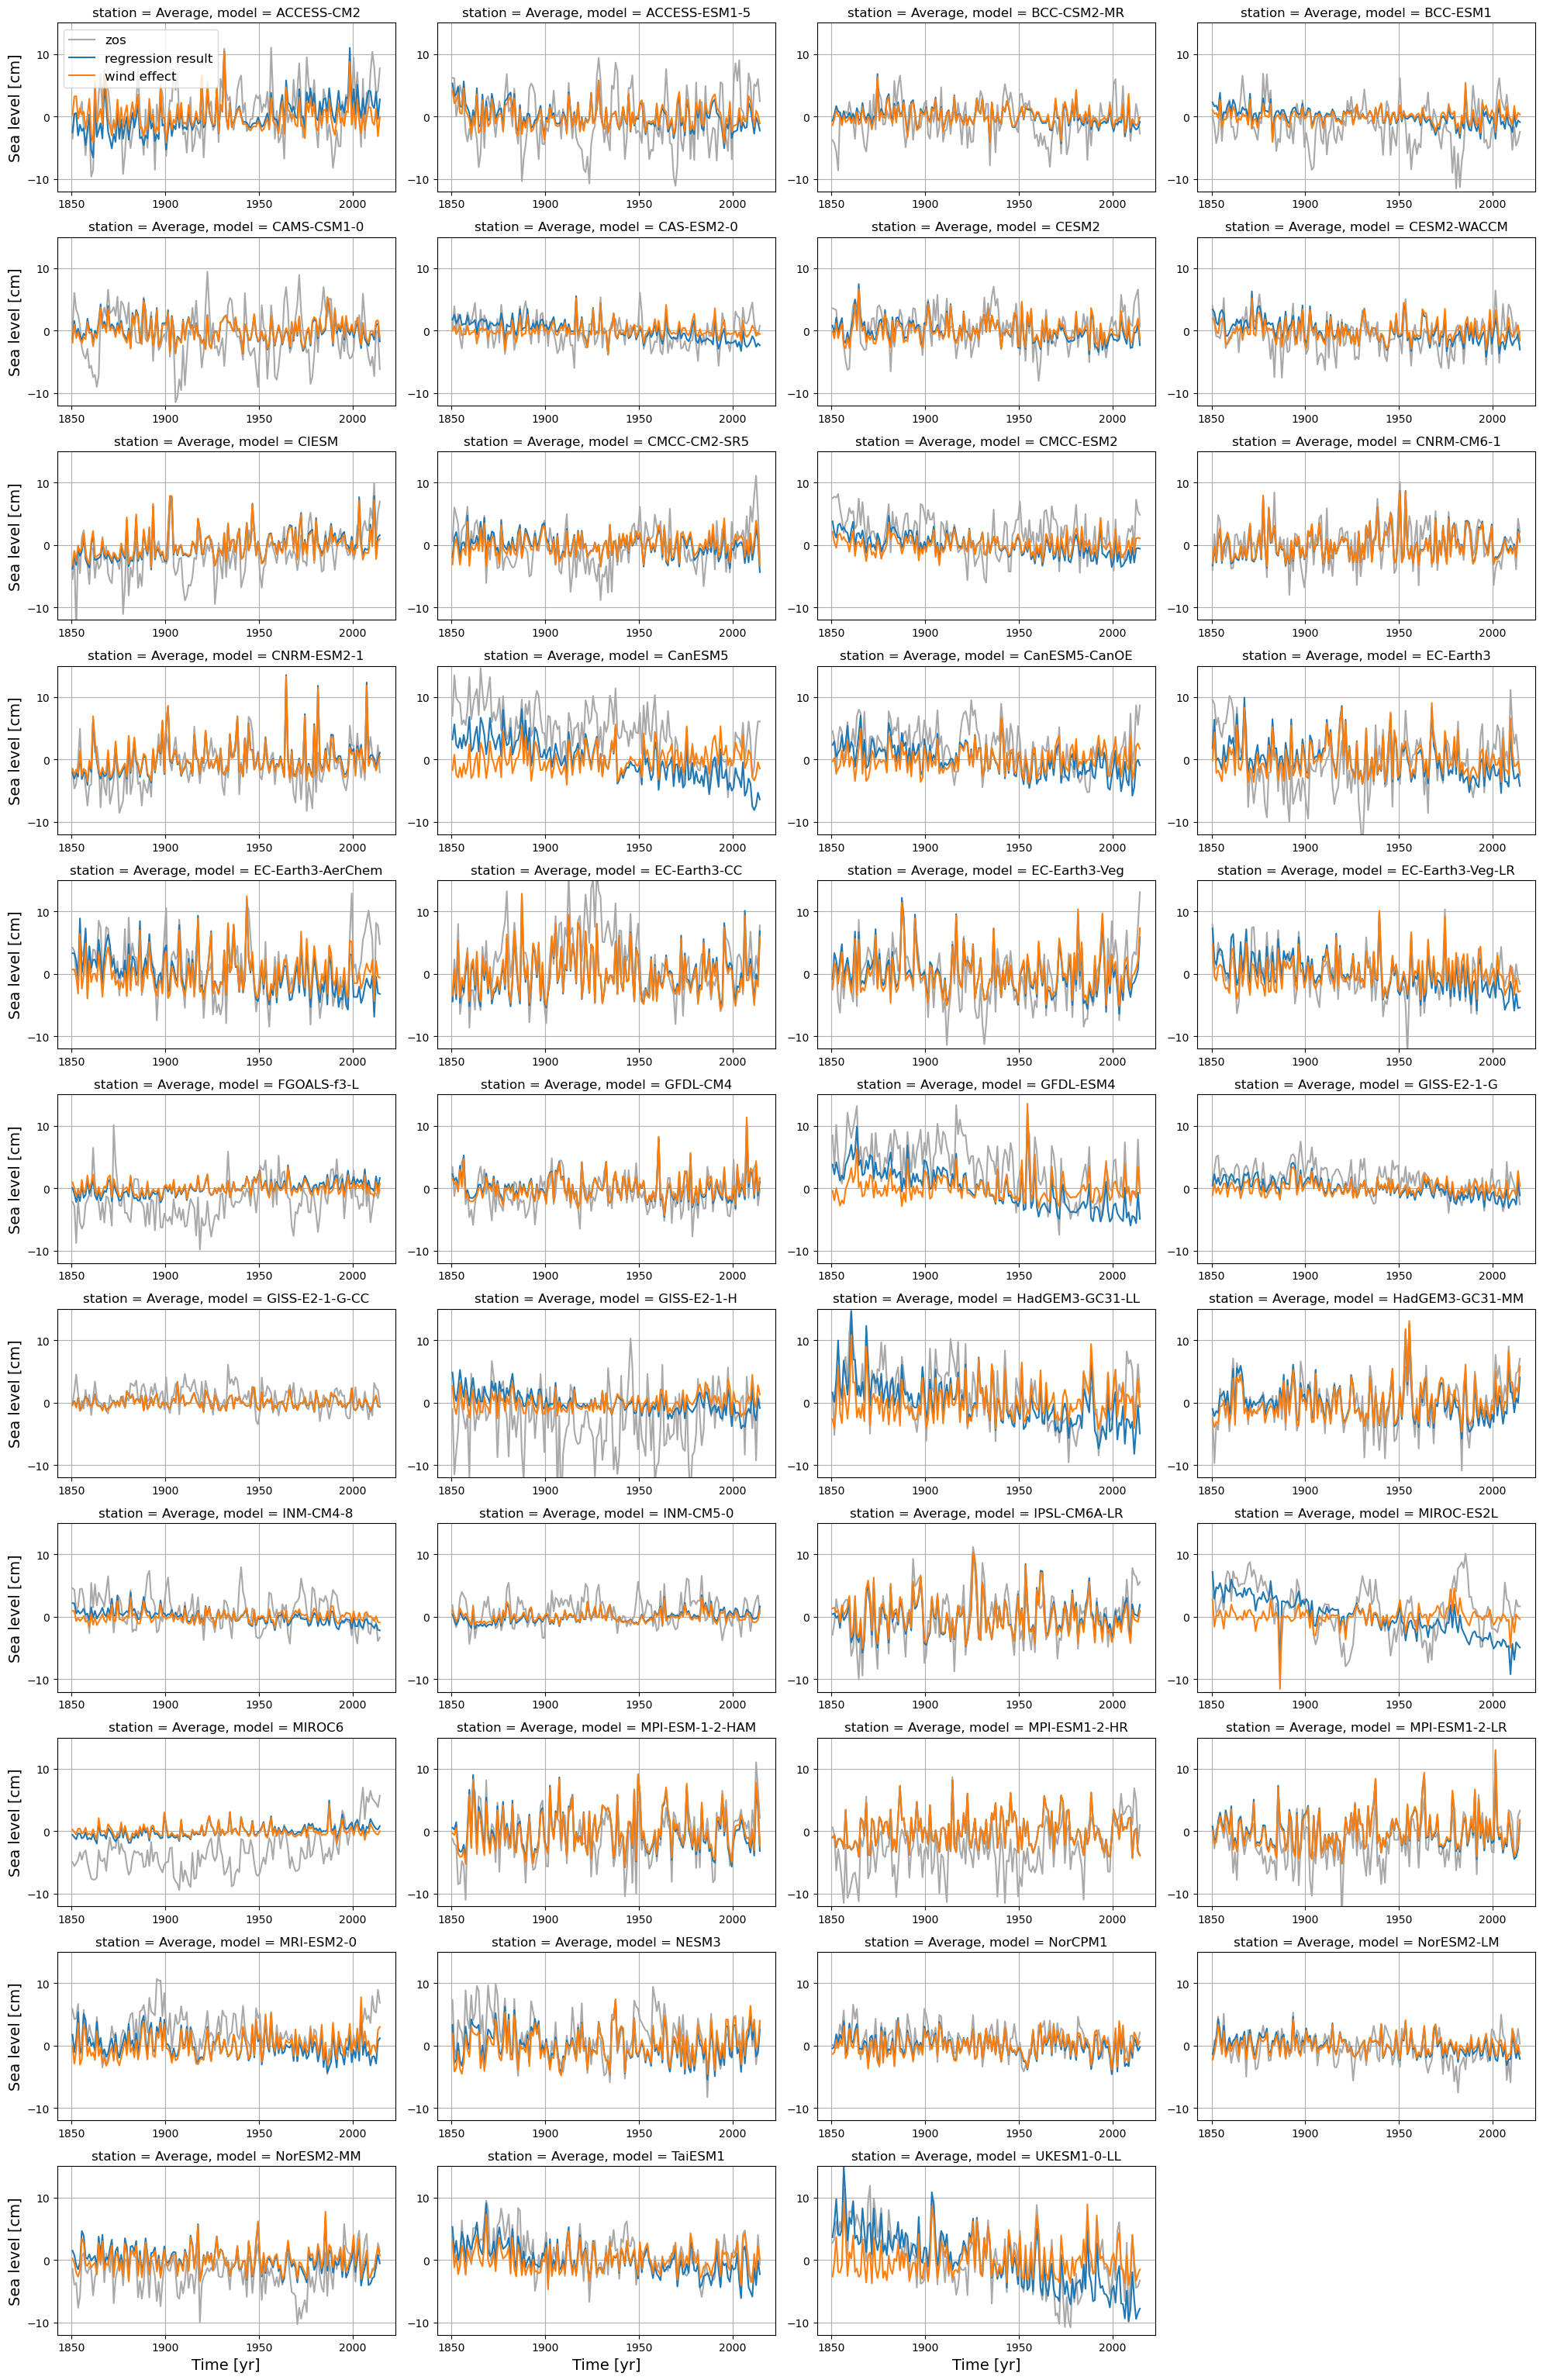

In [168]:
station = 'Average'

models = timeseries.model.values
nrows = 11
ncol = 4

fig, axs = plt.subplots(nrows, ncol, figsize=(5*ncol, 2.8*nrows))


for i in range(nrows):
    
    for j in range(ncol):
        ax = axs[i,j]
        
        if (i == nrows-1) and (j == ncol-1):
            fig.delaxes(axs[i,j])
        
        else: 
            
            sealevel_data.sel(station = station).isel(model = j + i*ncol).zos.plot(ax = ax, color = 'darkgray')
            timeseries.sel(station = station).isel(model = j + i*ncol).total.plot(ax = ax)
            timeseries.sel(station = station).isel(model = j + i*ncol).wind_total.plot(ax = ax)
            
            axs[i,j].set_ylim([-12,15])
            axs[i,j].grid()
        
        ax.set_yticks([-10, 0, 10], fontsize = 14)
        ax.set_xticks([1850, 1900, 1950, 2000], fontsize = 14)
        
        if i == nrows-1:
            ax.set_xlabel('Time [yr]', fontsize = 14)
        else:
            ax.set_xlabel('')
            
            
        if j == 0:
            ax.set_ylabel('Sea level [cm]', fontsize = 14)
        else:
            ax.set_ylabel('')
            
            
axs[0,0].legend(labels = ['zos', 'regression result', 'wind effect'], loc = 'upper left', fontsize = 12)
           
plt.tight_layout()



## Obtain wind effect for scenarios

### Import sea level and wind stress data

In [169]:
sealevel_data_ssp126 = xr.open_dataset(f'{path}/sealevel_ssp126.nc')
sealevel_data_ssp245 = xr.open_dataset(f'{path}/sealevel_ssp245.nc')
sealevel_data_ssp585 = xr.open_dataset(f'{path}/sealevel_ssp585.nc')


windstress_data_ssp126 = xr.open_dataset(f'{path}/windstress_ssp126.nc')
windstress_data_ssp245 = xr.open_dataset(f'{path}/windstress_ssp245.nc')
windstress_data_ssp585 = xr.open_dataset(f'{path}/windstress_ssp585.nc')

### Obtain projections of wind effect

In [186]:
# Import regression coefficients
results = xr.open_dataset(f'{path}/regression output/results_cmip6.nc')



def projections(sce_data, scenario):
    """
    Function to obtain the projections for the wind effect in the 21st century
    
    """
    
    # Create dataframe 
    df = pd.DataFrame({'time' : sce_data.time.data})
    df = df.set_index('time')
    
    
    wind_contr_mod = []
    
    # Get projections for each model
    for model in sce_data.model.data:
        
        # Import scalers for standardization
        file = open(f'{path}/regression output/scalers_{model}.pkl', "rb")
        scalers = pickle.load(file)
        
        wind_contr_stat = []
    
        # Get projections for each station
        for station in sce_data.station.data:
            
            # Obtain coefficients
            u2_coef = results.sel(model = model, station = station).u2.data
            v2_coef = results.sel(model = model, station = station).v2.data
    
            # Obtain wind timeseries
            df['u2_data'] = sce_data.u2.sel(model = model, station = station).data
            df['v2_data'] = sce_data.v2.sel(model = model, station = station).data
            
            
            # Standardize dataframe
            df.iloc[:,:] = scalers[station].fit_transform(df)
            
            
            # Obtain wind effect projections
            wind_contr = (u2_coef * df['u2_data'].values) + (v2_coef * df['v2_data'].values)
            
            # Append xarrat dataset to list
            wind_contr_stat.append(xr.Dataset(data_vars=dict(wind_total = (['time'], wind_contr),
                                                            time = sce_data.time.data)))
            
        # Append concatenated datasets to list
        wind_contr_mod.append(xr.concat(wind_contr_stat, dim = stations).rename({"concat_dim" : "station"}))
    
    # Obtain complete dataset
    wind_contr = xr.concat(wind_contr_mod, dim = sce_data.model.data).rename({"concat_dim" : "model"})
    
    # Save dataset
    wind_contr.to_netcdf(f'{path}/regression output/timeseries_cmip6_{scenario}.nc')
    
    return wind_contr



In [187]:
wind_proj_ssp126 = projections(windstress_data_ssp126, 'ssp126')
wind_proj_ssp245 = projections(windstress_data_ssp245, 'ssp245')
wind_proj_ssp585 = projections(windstress_data_ssp585, 'ssp585')

### Plot results for ssp126

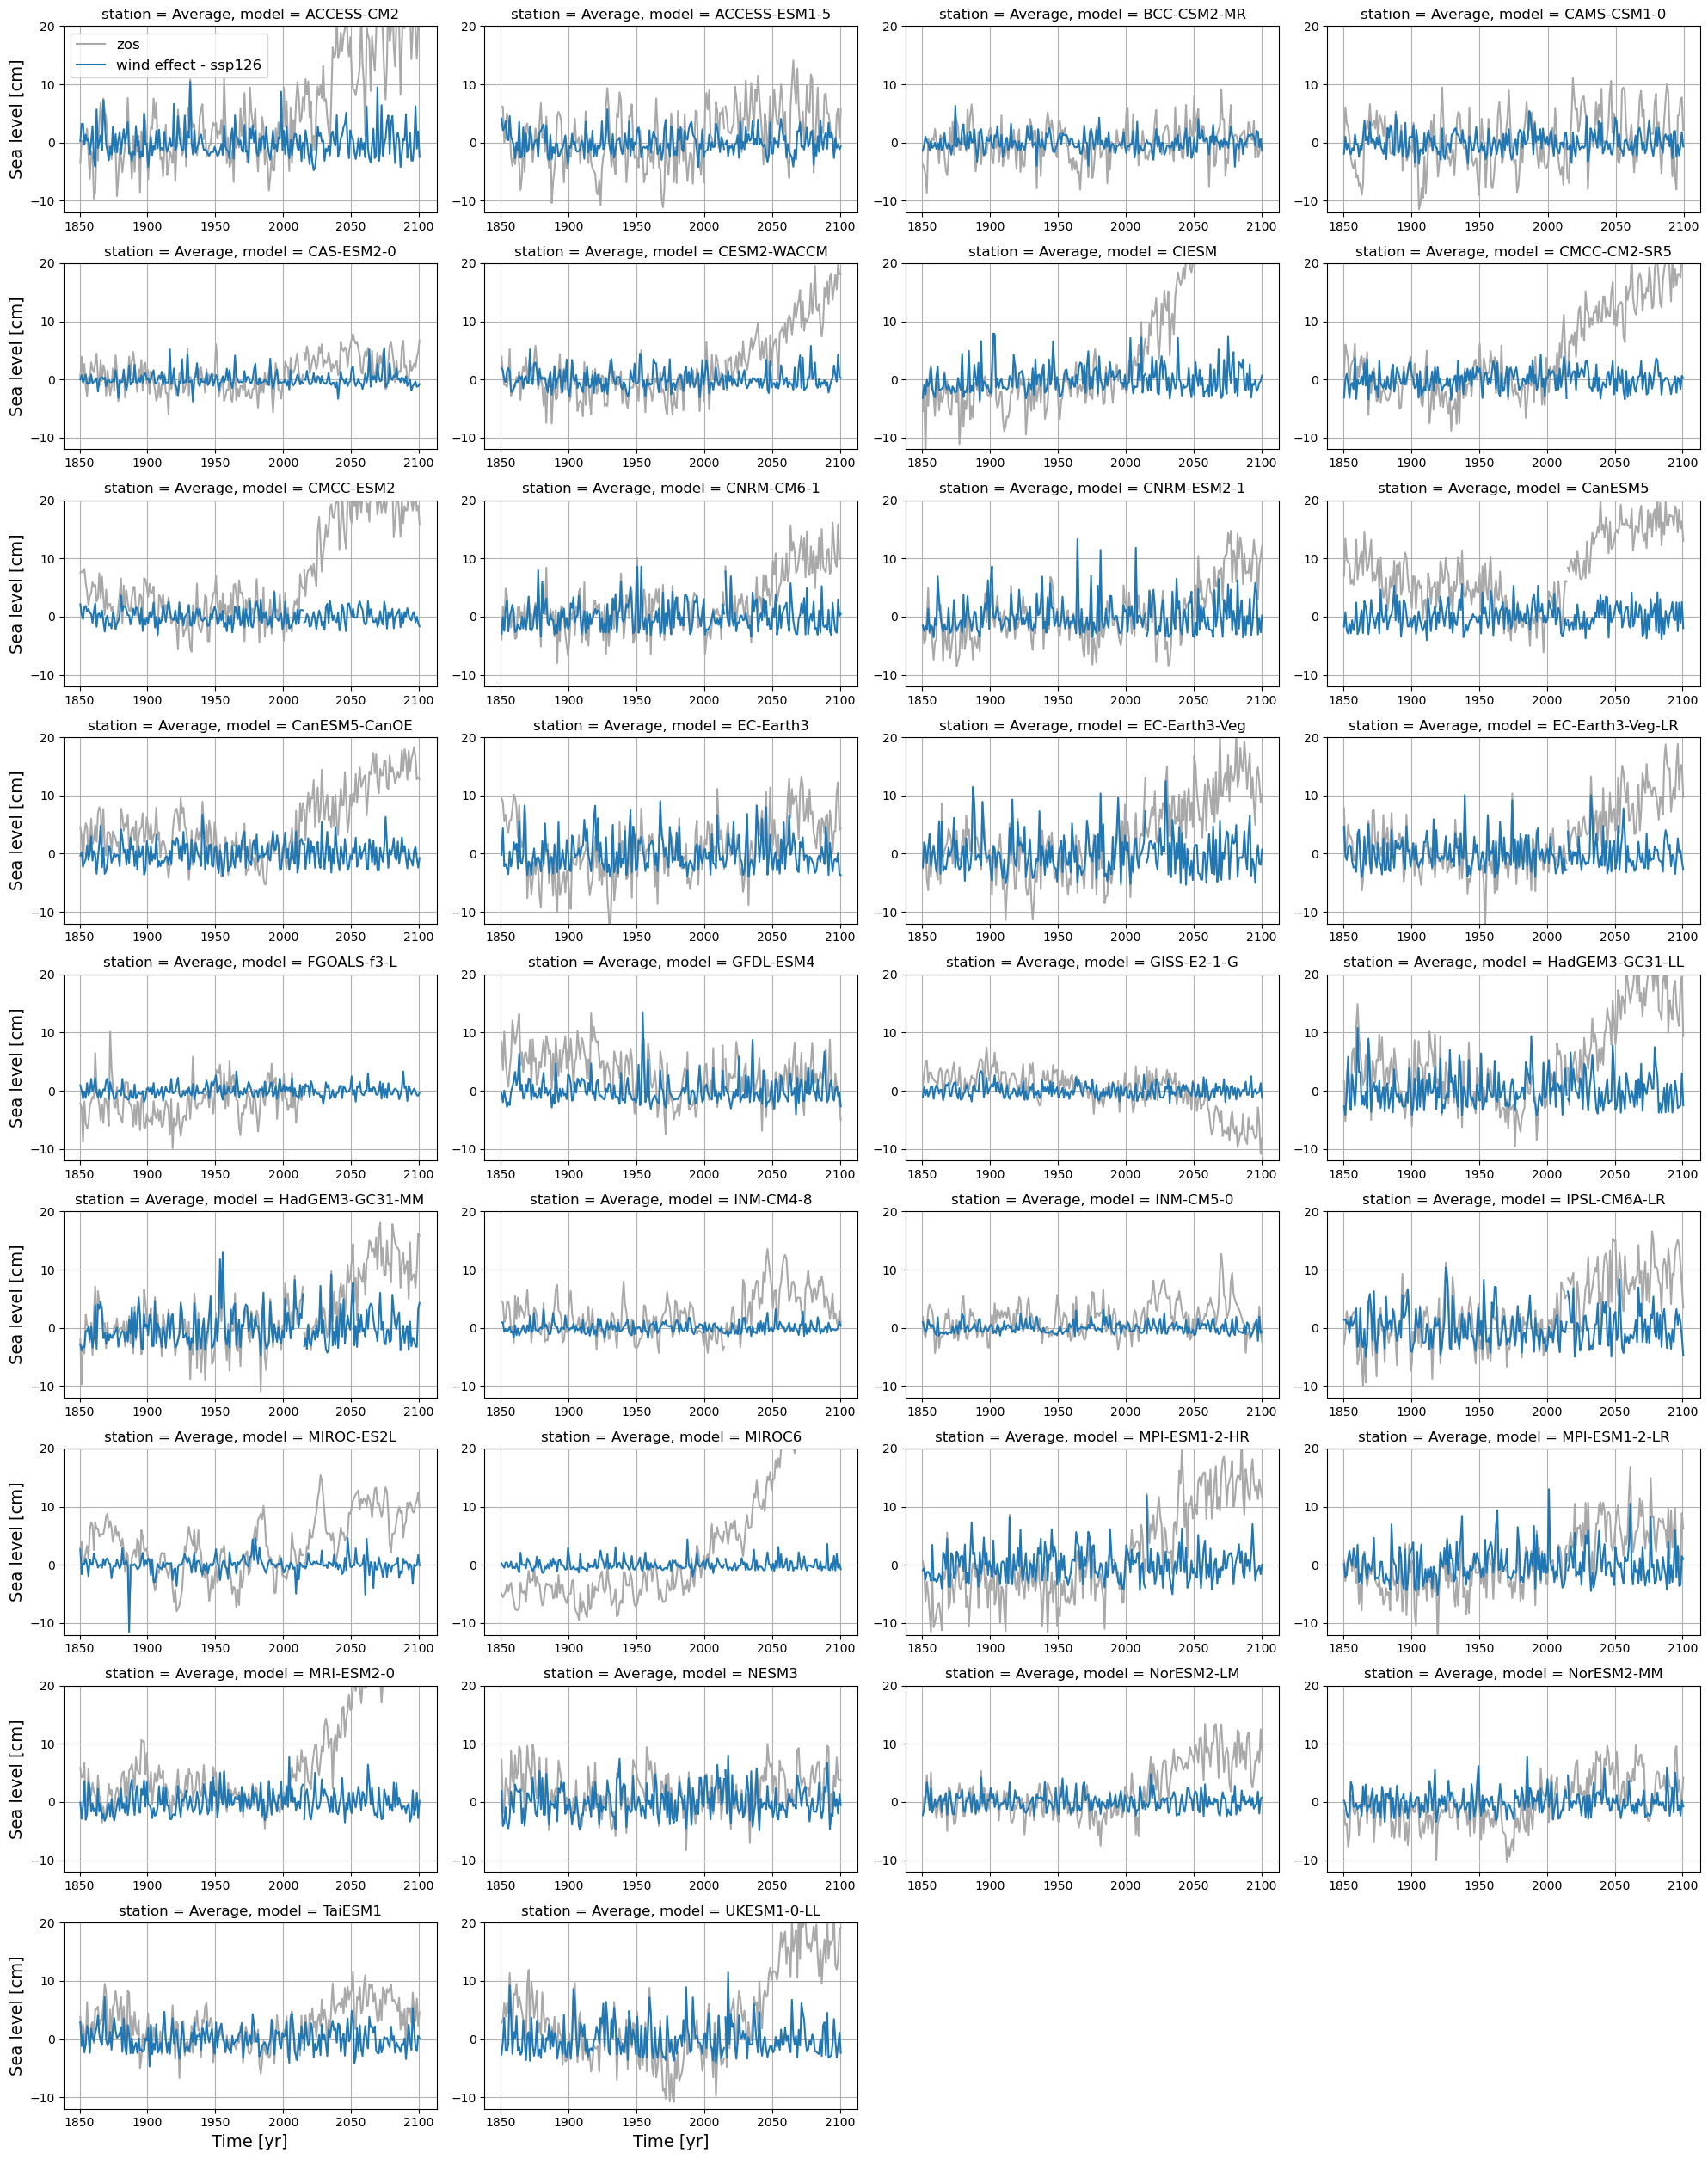

In [189]:
station = 'Average'

models = wind_proj_ssp126.model.values
nrows = 9
ncol = 4

fig, axs = plt.subplots(nrows, ncol, figsize=(5*ncol, 2.8*nrows))


for i in range(nrows):
    
    for j in range(ncol):
        ax = axs[i,j]
        
        if (i == nrows-1) and (j == ncol-1):
            fig.delaxes(axs[i,j])
        elif (i == nrows-1) and (j == ncol-2):
            fig.delaxes(axs[i,j])
        else: 
            
            model = wind_proj_ssp126.model.isel(model = j + i*ncol)
            
            sealevel_data.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            timeseries.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            if sealevel_data_ssp126.model.isin(model).any().data:
                sealevel_data_ssp126.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            wind_proj_ssp126.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            
            axs[i,j].set_ylim([-12,15])
            axs[i,j].grid()
        
        ax.set_yticks([-10, 0, 10, 20], fontsize = 14)
        ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100], fontsize = 14)
        
        if i == nrows-1:
            ax.set_xlabel('Time [yr]', fontsize = 14)
        else:
            ax.set_xlabel('')
            
            
        if j == 0:
            ax.set_ylabel('Sea level [cm]', fontsize = 14)
        else:
            ax.set_ylabel('')
            
            
axs[0,0].legend(labels = ['zos', 'wind effect - ssp126'], loc = 'upper left', fontsize = 12)
           
plt.tight_layout()


### Plot results for ssp245

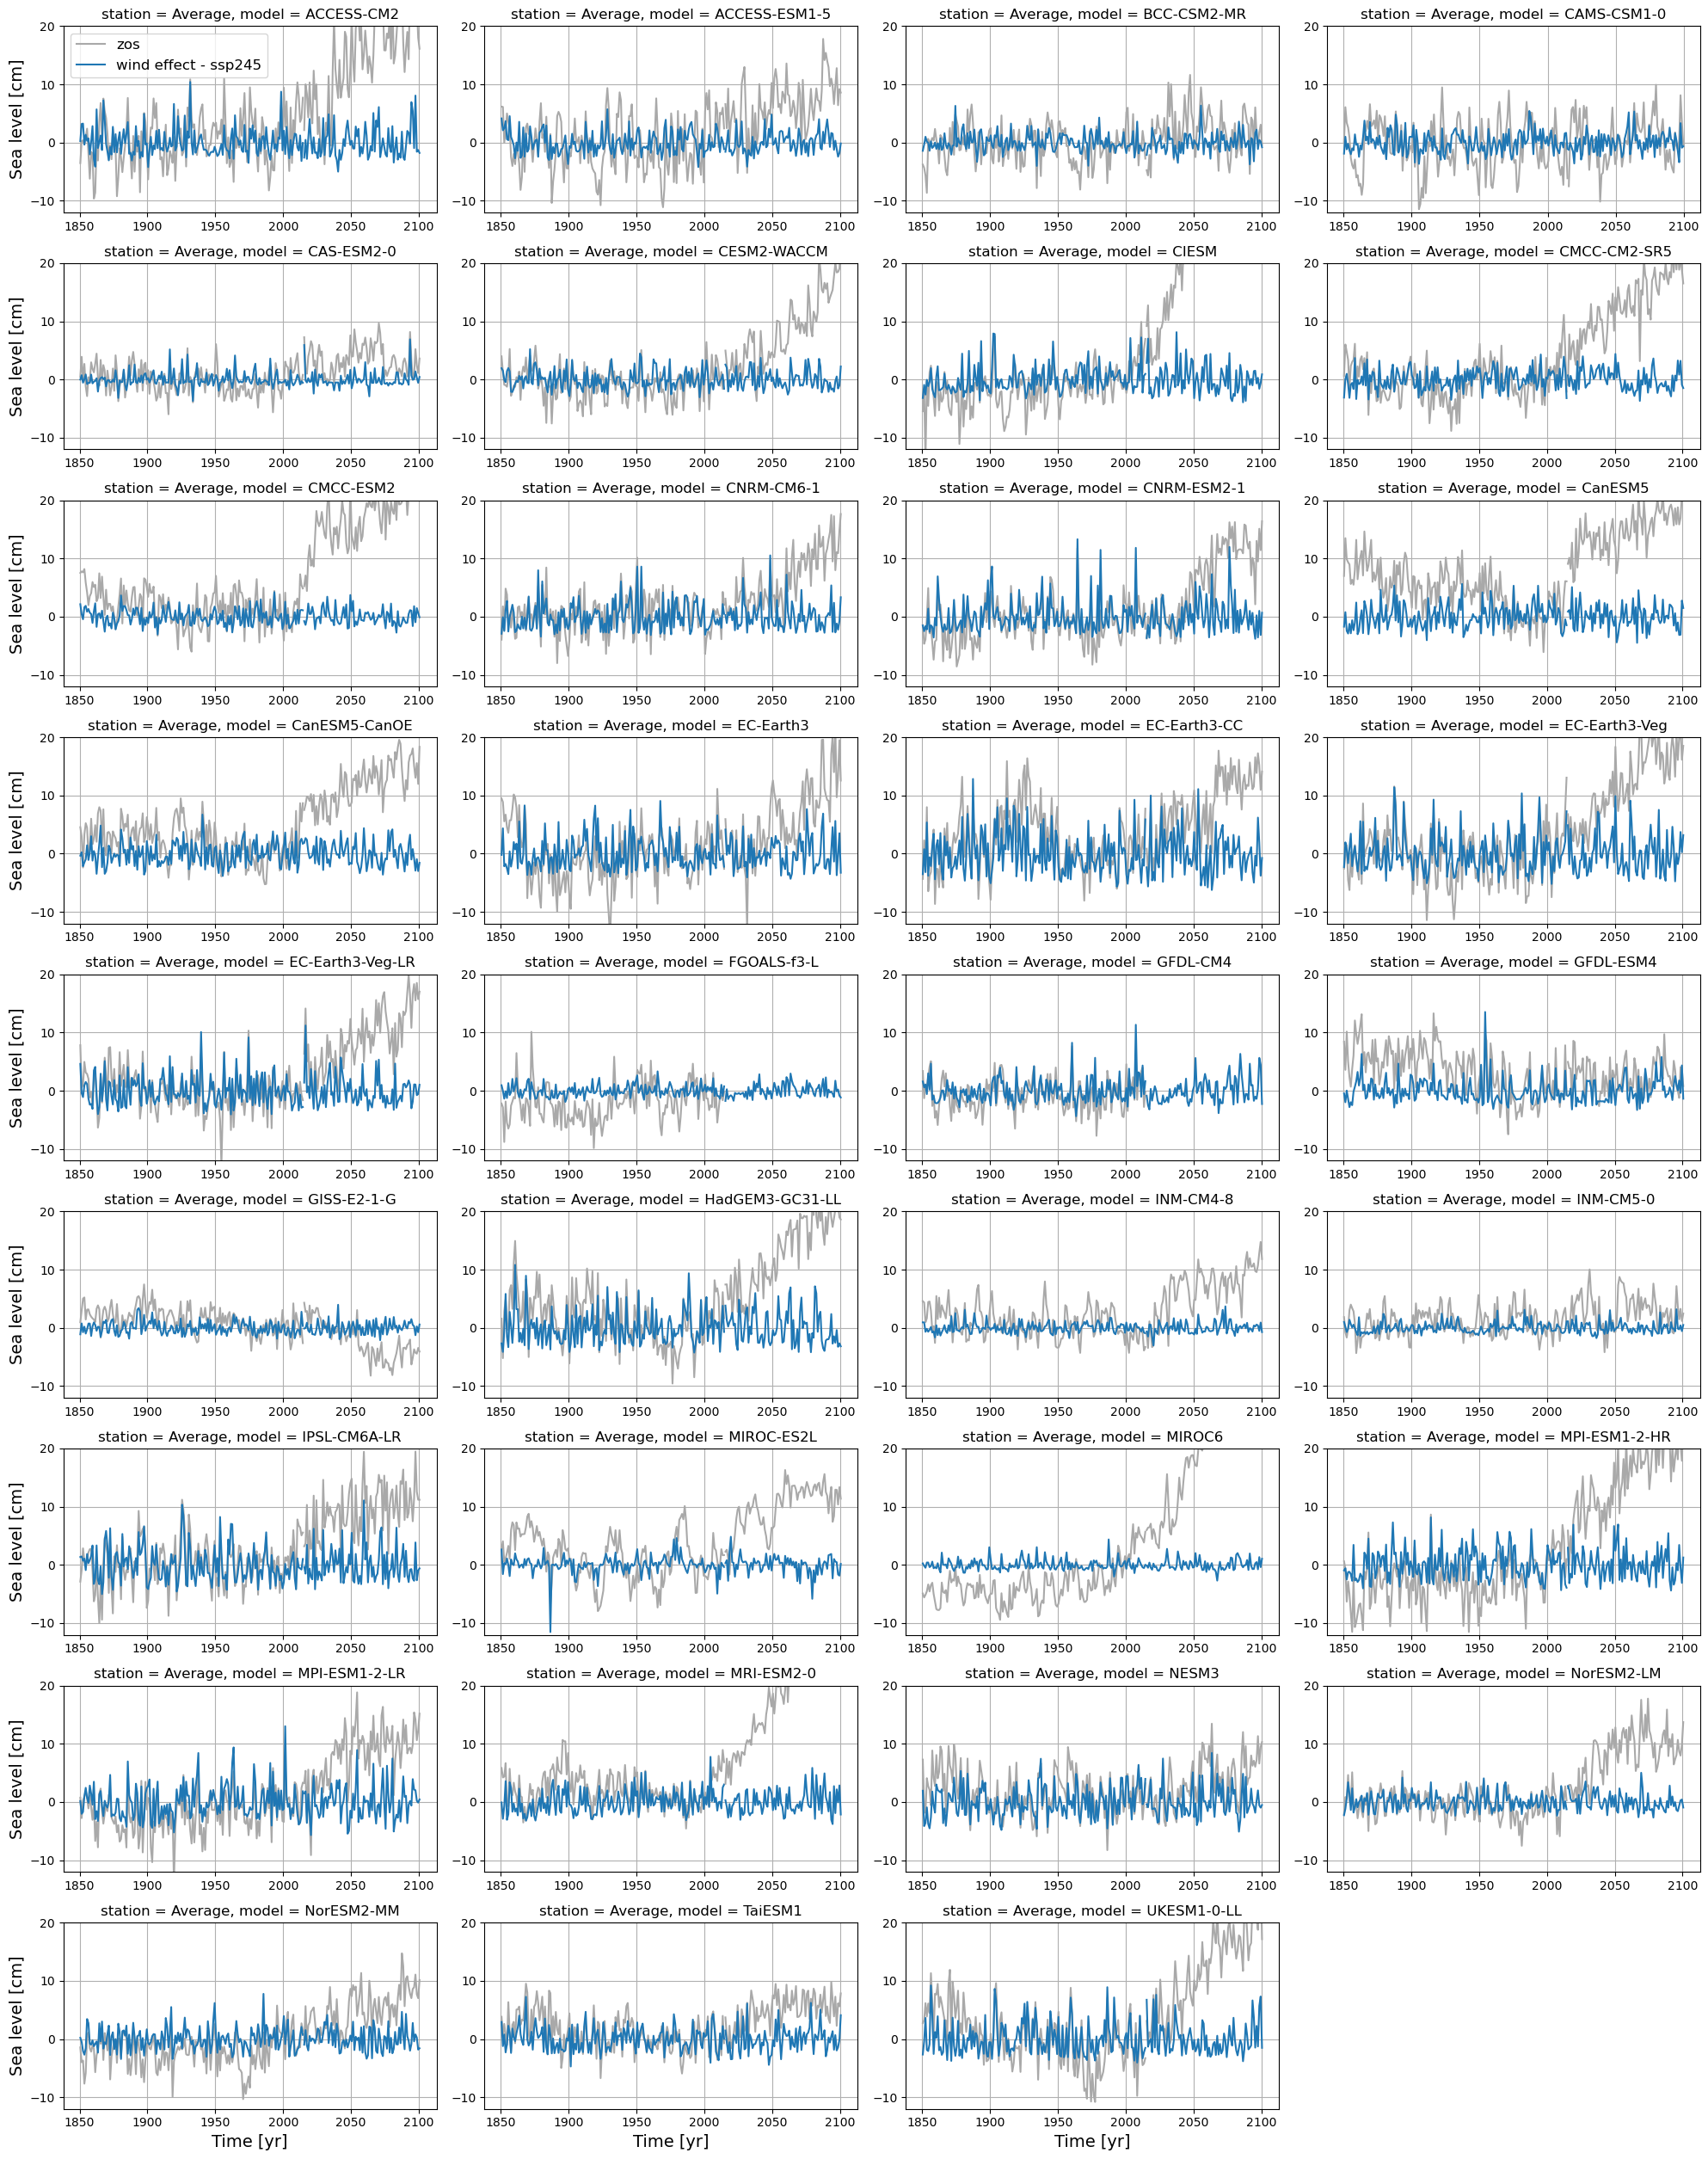

In [190]:
station = 'Average'

models = wind_proj_ssp245.model.values
nrows = 9
ncol = 4

fig, axs = plt.subplots(nrows, ncol, figsize=(5*ncol, 2.8*nrows))


for i in range(nrows):
    
    for j in range(ncol):
        ax = axs[i,j]
        
        if (i == nrows-1) and (j == ncol-1):
            fig.delaxes(axs[i,j])
        else: 
            
            model = wind_proj_ssp245.model.isel(model = j + i*ncol)
            
            sealevel_data.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            timeseries.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            if sealevel_data_ssp245.model.isin(model).any().data:
                sealevel_data_ssp245.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            wind_proj_ssp245.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            
            axs[i,j].set_ylim([-12,15])
            axs[i,j].grid()
        
        ax.set_yticks([-10, 0, 10, 20], fontsize = 14)
        ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100], fontsize = 14)
        
        if i == nrows-1:
            ax.set_xlabel('Time [yr]', fontsize = 14)
        else:
            ax.set_xlabel('')
            
            
        if j == 0:
            ax.set_ylabel('Sea level [cm]', fontsize = 14)
        else:
            ax.set_ylabel('')
            
            
axs[0,0].legend(labels = ['zos', 'wind effect - ssp245'], loc = 'upper left', fontsize = 12)
           
plt.tight_layout()


### Plot results for ssp585

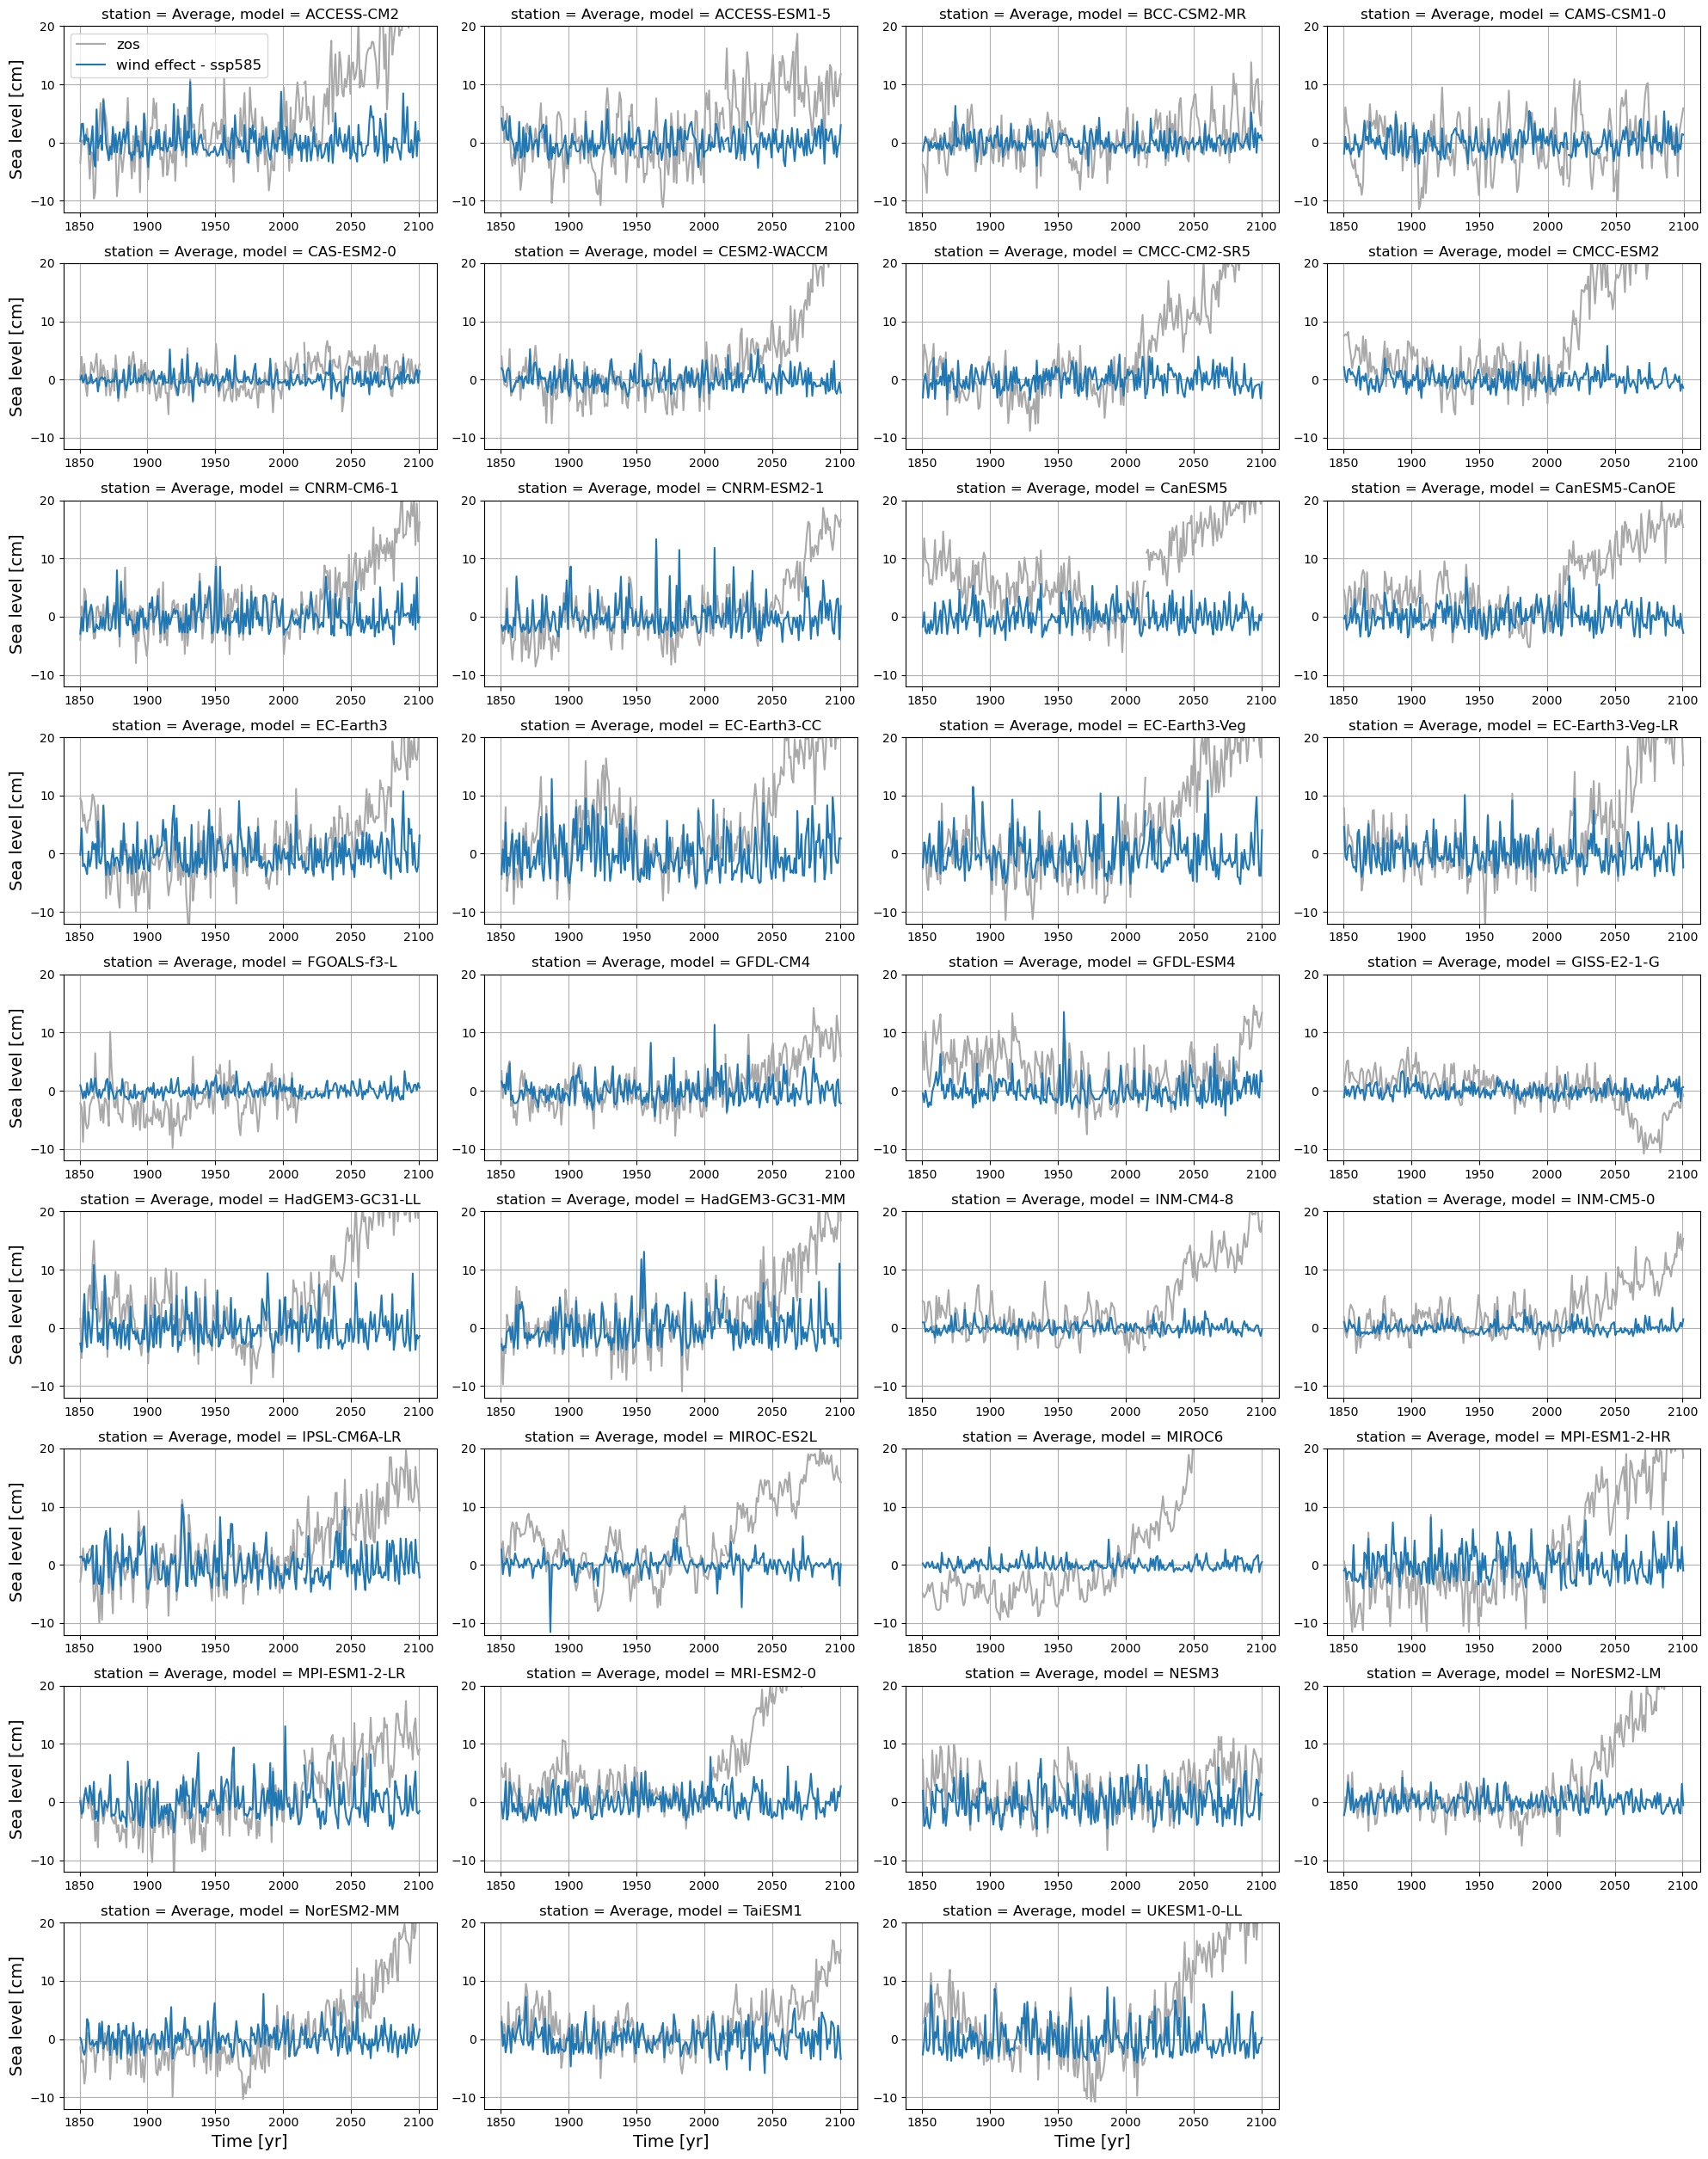

In [191]:
station = 'Average'

models = wind_proj_ssp585.model.values
nrows = 9
ncol = 4

fig, axs = plt.subplots(nrows, ncol, figsize=(5*ncol, 2.8*nrows))


for i in range(nrows):
    
    for j in range(ncol):
        ax = axs[i,j]
        
        if (i == nrows-1) and (j == ncol-1):
            fig.delaxes(axs[i,j])
        else: 
            
            model = wind_proj_ssp585.model.isel(model = j + i*ncol)
            
            sealevel_data.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            timeseries.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            if sealevel_data_ssp585.model.isin(model).any().data:
                sealevel_data_ssp585.sel(station = station, model = model).zos.plot(ax = ax, color = 'darkgray')
            wind_proj_ssp585.sel(station = station, model = model).wind_total.plot(ax = ax, color = 'tab:blue')
            
            
            axs[i,j].set_ylim([-12,15])
            axs[i,j].grid()
        
        ax.set_yticks([-10, 0, 10, 20], fontsize = 14)
        ax.set_xticks([1850, 1900, 1950, 2000, 2050, 2100], fontsize = 14)
        
        if i == nrows-1:
            ax.set_xlabel('Time [yr]', fontsize = 14)
        else:
            ax.set_xlabel('')
            
            
        if j == 0:
            ax.set_ylabel('Sea level [cm]', fontsize = 14)
        else:
            ax.set_ylabel('')
            
            
axs[0,0].legend(labels = ['zos', 'wind effect - ssp585'], loc = 'upper left', fontsize = 12)
           
plt.tight_layout()
